In [1]:
import os
import torch
import csv
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as data_utils


In [2]:
#constant declaration
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 30

In [3]:
# importing benign and mixed flow datasets from tran_feature_selection

# Re-enable these three lines when using real data instead of sample_flows.csv
%store -r benign_flows  
# %store -r mixed_flows
# %store -r features

# This is a subset of mixed data intended only for making sure the model works on our data format
# actual analysis should use benign_flows and mixed_flows that were stored by tran_feature_selection
# benign_flows = pd.read_csv("sample_flows.csv", index_col=None, delimiter=',') 

features_ori = ['flowInd', 'duration', 'numHdrDesc',
            'l4Proto', 'macPairs', 'dstPortClassN', 'numPktsSnt', 'numPktsRcvd',
            'numBytesSnt', 'numBytesRcvd', 'minPktSz', 'maxPktSz', 'avePktSize', 'stdPktSize', 'pktps', 'bytps',
            'pktAsm', 'bytAsm', 'ipMindIPID', 'ipMaxdIPID', 'ipMinTTL', 'ipMaxTTL', 'ipTTLChg', 'ipOptCnt',
            'tcpPSeqCnt', 'tcpSeqSntBytes', 'tcpSeqFaultCnt', 'tcpPAckCnt', 'tcpFlwLssAckRcvdBytes', 'tcpAckFaultCnt',
            'tcpInitWinSz', 'tcpAveWinSz', 'tcpMinWinSz', 'tcpMaxWinSz', 'tcpWinSzDwnCnt', 'tcpWinSzUpCnt',
            'tcpWinSzChgDirCnt', 'tcpOptPktCnt', 'tcpOptCnt', 'tcpMSS', 'tcpWS', 'tcpTmS', 'tcpTmER', 'tcpEcI',
            'tcpBtm', 'tcpSSASAATrip', 'tcpRTTAckTripMin', 'tcpRTTAckTripMax', 'tcpRTTAckTripAve',
            'tcpRTTAckTripJitAve', 'tcpRTTSseqAA', 'tcpRTTAckJitAve', 'icmpTCcnt', 'icmpEchoSuccRatio', 'icmpPFindex',
            'connSip', 'connDip', 'connSipDip', 'connSipDprt', 'connF',  'aveIAT', 'maxIAT', 
                'stdIAT', 'tcpISeqN', 'tcpUtm', 'tcpWinSzThRt']
benign_flows1 = pd.DataFrame(benign_flows[features_ori])

features = benign_flows1.columns
dim = len(features)

# target = []
# for i in range(len(benign_flows1.index)):
#     target.append(random.randint(0,1))
    
# target = np.asarray(target)


In [4]:
#dataset loading
train_tensor = torch.tensor(benign_flows[features].values.astype(np.float32))
train_loader = torch.utils.data.DataLoader(train_tensor, batch_size = BATCH_SIZE, shuffle = False)
print(train_tensor)

tensor([[1.5900e+02, 9.3910e-03, 1.0000e+00,  ..., 1.3915e+09, 8.1844e+05,
         0.0000e+00],
        [1.6400e+02, 0.0000e+00, 1.0000e+00,  ..., 1.4527e+09, 0.0000e+00,
         1.0000e+00],
        [4.8000e+01, 1.3913e-02, 1.0000e+00,  ..., 4.7576e+08, 1.2620e+05,
         0.0000e+00],
        ...,
        [1.0000e+00, 8.6398e+04, 1.0000e+00,  ..., 1.2685e+09, 3.3208e+06,
         0.0000e+00],
        [5.7000e+01, 8.6369e+04, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.7000e+01, 8.6369e+04, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


In [5]:
#encoder decoder 

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.enc1 = nn.Linear(in_features=dim, out_features=int(dim/2))
        self.enc2 = nn.Linear(in_features=int(dim/2), out_features=int(dim/4))
        self.enc3 = nn.Linear(in_features=int(dim/4), out_features=int(dim/8))
        #self.enc4 = nn.Linear(in_features=int(dim/4), out_features=int(dim/8))
        
        # decoder 
        self.dec1 = nn.Linear(in_features=int(dim/8), out_features=int(dim/4))
        self.dec2 = nn.Linear(in_features=int(dim/4), out_features=int(dim/2))
        self.dec3 = nn.Linear(in_features=int(dim/2), out_features=dim)
        #self.dec4 = nn.Linear(in_features=dim, out_features=dim)
        
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        
        #sigmoid activation
#         x = F.sigmoid(self.enc1(x))
#         x = F.sigmoid(self.enc2(x))
#         x = F.sigmoid(self.enc3(x))
#         #x = F.relu(self.enc4(x))

#         x = F.sigmoid(self.dec1(x))
#         x = F.sigmoid(self.dec2(x))
#         x = F.sigmoid(self.dec3(x))
        #x = F.relu(self.dec4(x))
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Autoencoder()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

#print(net)

In [ ]:
#Trainning model

loss_function = nn.BCEWithLogitsLoss()  #MSELoss too
get_loss = list()
def training(net, trainloader, epochs):
    train_loss = []
    for epoch in range(epochs):
        running_loss = 0.0
        print(f"Running {epoch}")
        for data in train_loader:
            input_data = data.to(device=device)
            optimizer.zero_grad()
            output = net(input_data)          # output is the reconstruced x 
            loss = loss_function(output,input_data) # input_data should be the target variable
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        
#         if epoch % 5 == 0:
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
        epoch+1, NUM_EPOCHS, loss))
    return train_loss

get_loss = training(net, train_loader, NUM_EPOCHS)
get_loss
#plotting of get_loss 

_, ax = plt.subplots(1,1,figsize=(15,10))
plt.xlabel("epochs")
plt.ylabel("loss value ")
ax.set_title('Loss graph')
ax.plot(get_loss)
            

Running 0
Epoch 1 of 50, Train Loss: -49511769261573876482048.000
Running 1
Epoch 2 of 50, Train Loss: -60351378555775114805248.000
Running 2
Epoch 3 of 50, Train Loss: -67695184595989391474688.000
Running 3
Epoch 4 of 50, Train Loss: -74348847127715785998336.000
Running 4
Epoch 5 of 50, Train Loss: -80580695233539543662592.000
Running 5
Epoch 6 of 50, Train Loss: -87093254835367336476672.000
Running 6
Epoch 7 of 50, Train Loss: -93909802155600926212096.000
Running 7
Epoch 8 of 50, Train Loss: -101053512450107122909184.000
Running 8


In [33]:
#Prediction threshold 

net.eval()

loss_distr = []

test_data = pd.read_csv("mixed_flows.csv", index_col=None, delimiter=',') # when loading from csv  

# test_data = pd.DataFrame(mixed_flows)                                   # when loading from stored data

for i in range(len(test_data)):
    data = torch.from_numpy(np.array(test_data).float())
    input_sample = net(data.to(device))
    loss = loss_function(data.to(device), input_sample)
    loss_distr.append(loss.item())

loss_sc = []
for i in loss_distr:
    loss_sc.append((i,i))
plt.scatter(*zip(*loss_sc))
plt.axvline(0, 0, 1)
                            
    

FileNotFoundError: [Errno 2] File mixed_flows.csv does not exist: 'mixed_flows.csv'

C:\Users\arifu\anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


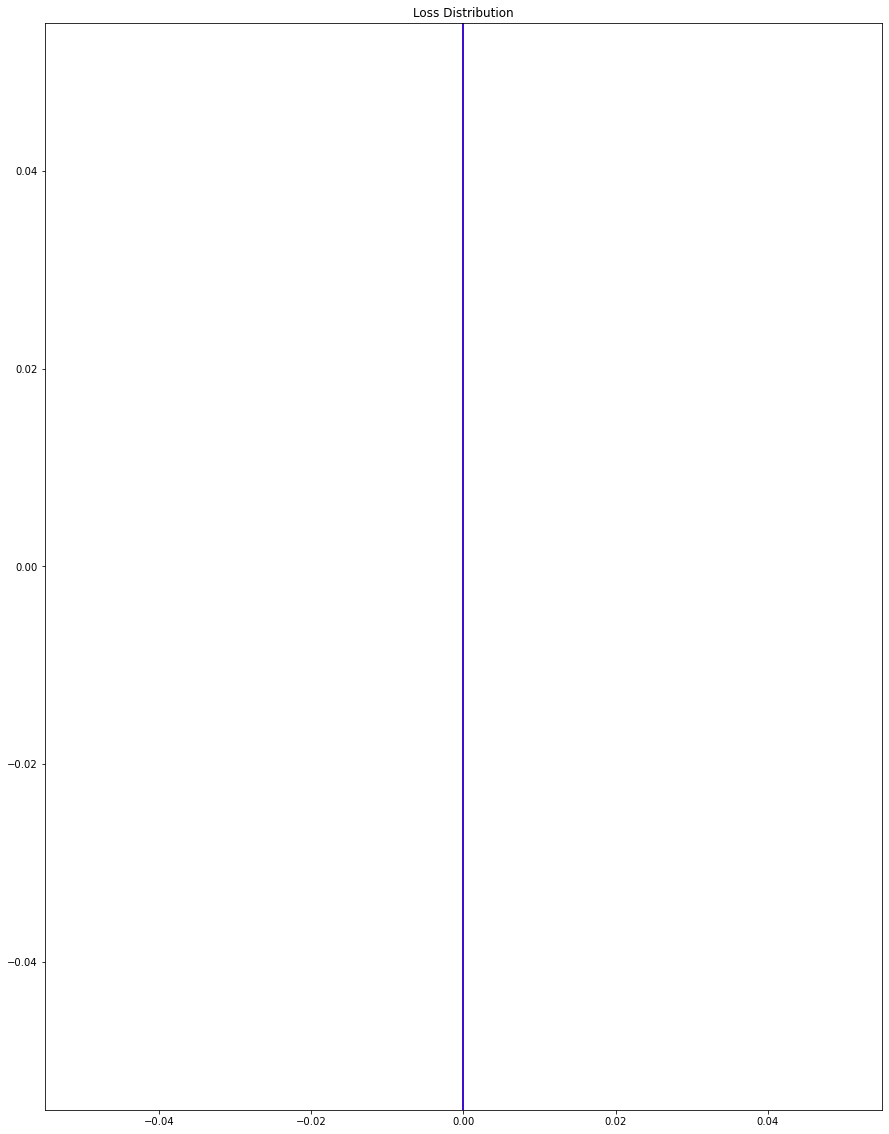

In [34]:
lower_threshold = 0   #have to find the threshold
upper_threshold = 0
plt.figure(figsize=(15,20))
plt.title('Loss Distribution')
sns.distplot(loss_distr,bins=100,kde=True, color='blue')
plt.axvline(upper_threshold, 0.0,10 , color='r')
plt.axvline(lower_threshold, 0.0,10 , color='b')